In [1068]:
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform, EssentialMatrixTransform, FundamentalMatrixTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

import pandas as pd
import numpy as np
import os

In [1069]:
def get_parameters(dino_param_df):
    """
    Read the text file to get the parmeters of interest: K, R, T
    """

    param_dict = {}

    for i in range(len(dino_param_df)):
        row = dino_param_df.loc[i]
        K = np.array(row.loc[1:9].tolist()).reshape(3,3)
        R = np.array(row.loc[10:18].tolist()).reshape(3,3)
        T = np.array(row.loc[19:].tolist()).reshape(3,1)

        # param_dict[dino_param_df.loc[i][0]] = [K, R, T]
        param_dict[i] = [K, R, T]
    
    return param_dict


def get_translation_matrix(T):
    """
    T_mat = [ 0  -a3 a2]
            [ a3  0 -a2]
            [-a2 a1  0 ]
    """
    a1, a2, a3 = T

    T_mat = np.zeros((3,3))
    T_mat[0, 1] = -a3
    T_mat[0, 2] = a2
    T_mat[1, 0] = a3
    T_mat[1, 2] = -a2
    T_mat[2, 0] = -a2
    T_mat[2, 1] = a1

    return T_mat


def get_E_matrix(T, R):
    """
    E = [T]_x R
    """

    T_cross = get_translation_matrix(T)

    E_mat = T_cross @ R

    return E_mat

def get_F_matrix(K, E):
    """
    F = K^-T E K^T
    """

    F_mat = np.linalg.inv(K.T) @ E @ K.T

    return F_mat

In [1070]:
# Read the original text file
path_to_dino_imgs = os.path.join(os.getcwd(), 'dinoSparseRing', 'dinoSR_par.txt')

dino_param_df = pd.read_table(path_to_dino_imgs, header=None, skiprows=[0], delim_whitespace=True)

In [1071]:
# Reorganize the params
dino_params = get_parameters(dino_param_df=dino_param_df)

## Start with only two camera centers

In [1072]:
C1_params = dino_params[0]
C2_params = dino_params[1]

In [1080]:
# Calculate the Essential Matrix
    # Ci_params =  [K, R, T]

K1, R1, T1 = C1_params
K2, R2, T2 = C2_params

R_rel = np.linalg.inv(R1) @ R2
T_rel = T2 - T1

E = get_E_matrix(T = T_rel, R = R_rel)
# Calculate the Fundamental Matrix using K^-T E K^T

F = get_F_matrix(K = R_rel, E = E)

F

array([[ 0.00059732,  0.01108194, -0.00189644],
       [-0.0137689 , -0.0003169 ,  0.00215244],
       [ 0.00211997, -0.00908169,  0.00080979]])

In [1081]:
def get_bound_box_intensities(im, point, bounding_box_size):

    i = bounding_box_size//2
    u,v = point[0], point[1]
    if (type(u) == int) and (type(v) == int):
        l_min, l_max = u - i, u + i
        r_min, r_max = v - i, v + i

        #bb_int = im[l_min:(l_max+1), r_min:(r_max+1), :]
    else:
        if (type(u) == int):
            v_lower = int(np.floor(v))
            v_higher = int(np.ceil(v))

            l_min, l_max = int(u - i), int(u + i)
            r_min_lower, r_max_lower = v_lower - i, v_lower + i
            r_min_higher, r_max_higher = v_higher - i, v_higher + i

            bb_int_list = [im[l_min:(l_max+1), r_min_lower:(r_max_lower+1), :], \
                            im[l_min:(l_max+1), r_min_higher:(r_max_higher+1), :]]
                            
            # if np.argmax(bb_int_list) == 0:
            #     r_min, r_max = r_min_lower, r_max_lower
            #     v = v_lower
            # else:
            #     r_min, r_max = r_min_higher, r_max_higher
            #     v = v_higher
            
            return bb_int_list, v_lower, v_higher

        else:
            u_lower = int(np.floor(u))
            u_higher = int(np.ceil(u))

            r_min, r_max = int(v - i), int(v + i)
            l_min_lower, l_max_lower = u_lower - i, u_lower + i
            l_min_higher, l_max_higher = u_higher - i, u_higher + i

            bb_int_list = [im[l_min_lower:(l_max_lower+1), r_min:(r_max+1), :], \
                            im[l_min_higher:(l_max_higher+1), r_min:(r_max+1), :]]
            
            # if np.argmax(bb_int_list) == 0:
            #     l_min, l_max = l_min_lower, l_max_lower
            #     u = u_lower
            # else:
            #     l_min, l_max = l_min_higher, l_max_higher
            #     u = u_higher
            
            return bb_int_list, u_lower, u_higher


def loss_function(image_point, image_point_2, bb_int_L, bb_int_R):

    # Photoconsistency (?) + (Positional Consistency)
    loss = np.sum(np.square(bb_int_L - bb_int_R)) + np.sum(np.abs(image_point - image_point_2))

    return loss

def get_match_points(imL, imR, x1, F, bounding_box_size):

    # Define some common variables:
    l,w,c = np.shape(imL)

    final_R_points_list = []
    epipolar_line_L_list, epipolar_line_R_list = [], []
    u, v = np.arange(l-1), np.arange(w-1)
    
    for i in range(len(x1)):

        # (u,v) of interest
        image_point = np.array([x1[i, 0], x1[i, 1]])
        # (u,v,1)
        image_point_homo = np.hstack([image_point, 1])
        # Current l1 = Fx
        l1 = np.dot(F, image_point_homo.T)
        
        # Calculate all possible points on epipolar line
        u_pt_on_l1_not_int = -(1/l1[0])*(v*l1[1]+l1[2])
        
        # Indices of the second image
        x2_on_eline = np.vstack([u_pt_on_l1_not_int, v]).T
        # # Location out NOT out of bounds
        x2_on_eline = x2_on_eline[np.where((x2_on_eline[:, 0] < l - bounding_box_size) & \
                                     (x2_on_eline[:, 0] > bounding_box_size) & \
                                     (x2_on_eline[:, 1] < w - bounding_box_size) & \
                                     (x2_on_eline[:, 1] > bounding_box_size))]
        
        # Which point on the second image corresponds to image_point:
        # Epipolar line on the second image
        epipolar_line_R_list.append([u_pt_on_l1_not_int, v])
        
        bb_int_L, _, _ = get_bound_box_intensities(imL, image_point, bounding_box_size)

        final_loss_list = []
        final_image_point_2_list = []
        
        for i in range(len(x2_on_eline)):
            # Testing if current point on epipolar line in image 2 works
            image_point_2 = x2_on_eline[i, :]
            
            # Return the (bounding_box_size x bounding_box_size x 3)
            bb_int_R_list, u_lower, u_higher = get_bound_box_intensities(imR, image_point_2, bounding_box_size)            

            # Custom loss functino
            image_point_2_list= [np.array([u_lower, image_point_2[1]]), np.array([u_higher, image_point_2[1]])]
            
            # bb_int_L[0] = bb_int_L[1] since the image_point are all ints to begin with
            loss_list = [loss_function(bb_int_L, bb_int_R_list[0], image_point, image_point_2_list[0]), \
                            loss_function(bb_int_L, bb_int_R_list[1], image_point, image_point_2_list[1])]

            loss_arg = np.argmin(loss_list)
            
            image_point_2 = image_point_2_list[loss_arg]
            loss = loss_list[loss_arg]
            
            final_image_point_2_list.append(image_point_2)
            final_loss_list.append(loss)

        
        final_R_point = final_image_point_2_list[np.argmin(final_loss_list)]
        
        image_point_2_homo = np.hstack([final_R_point, 1])

        l2 = np.dot(image_point_2_homo.T, F)

        v_pt_on_l2_not_int = -(1/l2[1])*(u*l2[0]+l2[2])

        epipolar_line_L_list.append([u, v_pt_on_l2_not_int])
        final_R_points_list.append(final_R_point)

    
    final_R_points = np.array(final_R_points_list)
    epipolar_line_L, epipolar_line_R = np.array(epipolar_line_L_list), np.array(epipolar_line_R_list)

    return final_R_points, epipolar_line_L, epipolar_line_R

# R_points, e_L, e_R = get_match_points(imL, imR, x1, F, 5)


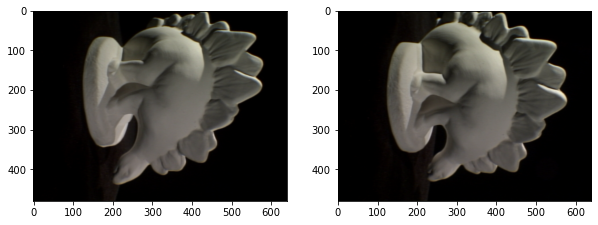

In [1082]:
# Test using two images:
    # - WHEN THINGS WORKS, USE THIS CODE CHUNK TO RUN THROUGH ALL THE IMAGES

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("dinoSparseRing/dinoSR0001.png")
imR = image.imread("dinoSparseRing/dinoSR0002.png")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

In [1083]:
# SAMPLE RANDOM INDICES
l,w,c = np.shape(image.imread("dinoSparseRing/dinoSR0001.png"))
# Keep this an odd number to make things easier
bounding_box_size = 10
num_feature_points = 5

mask = np.where(np.sum(imL, axis = 2) > 0.15, 1, 0)
points = np.array(np.where(mask == 1)).T

idx = np.random.choice(np.arange(points.shape[0]), size = num_feature_points)

x1 = points[idx]

In [1084]:
R_points, e_L, e_R = get_match_points(imL, imR, x1, F, 10)


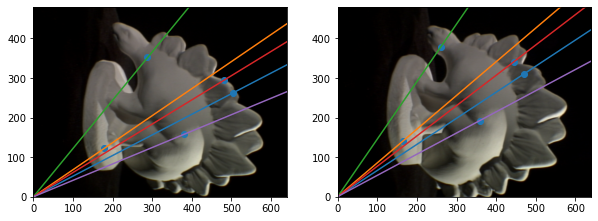

In [1085]:
plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
plt.scatter(x1[:, 1], x1[:, 0])
for i in range(len(e_L)):
    plt.plot(e_L[i][1], e_L[i][0])
plt.xlim(0, w)
plt.ylim(0, l)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.scatter(R_points[:, 1], R_points[:, 0])
for i in range(len(e_R)):
    plt.plot(e_R[i][1], e_R[i][0])
plt.xlim(0, w)
plt.ylim(0, l)
plt.show()

In [ ]:
# # Map these indices to the second image using F
# x1_homo = np.hstack([x1, np.ones(shape=(len(x1), 1), dtype=int)])
# x1_homo


# # each column represents the coefficients of line equation of l1 = Fx2
# Fx = np.dot(F, x1_homo.T)

# final_R_points_list = []
# epipolar_line_L_list = []
# epipolar_line_R_list = []
# u = np.arange(l-1)
# v = np.arange(w-1)
# for i in range(len(x1)):
    
#     original_L_point = np.array([x1[i, 0], x1[i, 1]])
#     l1 = Fx[:, i]
#     u_pt_on_l1_not_int = -(1/l1[0])*(v*l1[1]+l1[2])
    
#     u_pt_on_l1 = np.around(u_pt_on_l1_not_int.astype('int'))
    

#     # Indices of the second image
#     x2_on_eline = np.vstack([u_pt_on_l1, v]).T
#     # # Location out NOT out of bounds
#     x2_on_eline = x2_on_eline[x2_on_eline[:, 0] < l - bounding_box_size, :]
#     x2_on_eline = x2_on_eline[x2_on_eline[:, 0] > bounding_box_size, :]

#     x2_on_eline = x2_on_eline[x2_on_eline[:, 1] < w - bounding_box_size, :]
#     x2_on_eline = x2_on_eline[x2_on_eline[:, 1] > bounding_box_size, :]
    
#     if len(x2_on_eline) != 0:
#         epipolar_line_R_list.append([u_pt_on_l1_not_int, v])
#         bb_int_L = get_bound_box_intensities(imL, original_L_point, bounding_box_size)
#         loss_list = []
#         for i in range(len(x2_on_eline)):
            
#             point = x2_on_eline[i, :]
#             bb_int_R = get_bound_box_intensities(imR, point, bounding_box_size)

#             if len(bb_int_R) != 0:

#                 loss = np.sum(np.square(bb_int_L - bb_int_R)) + (1/2)*np.sum(np.abs(original_L_point - point))
#                 loss_list.append(loss)

#         final_R_point = x2_on_eline[np.argmin(loss_list), :]
#         xF = np.dot((np.hstack([final_R_point, 1])).T, F)
#         l2 = xF
#         v_pt_on_l2_not_int = -(1/l2[1])*(u*l2[0]+l2[2])
#         epipolar_line_L_list.append([u, v_pt_on_l2_not_int])

#         final_R_points_list.append(final_R_point)

# final_R_points = np.array(final_R_points_list)



In [796]:
mask[(x1[:, 0], x1[:, 1])]

# x1[0, 0], x1[0, 1]

array([1, 1])

In [797]:
# proper_points_list = []

# i = 0

# original_L_point = np.array([x1[i, 0], x1[i, 1]])
# l1 = Fx[:, i]
# u_pt_on_l1 = -(1/l1[0])*(v*l1[1]+l1[2])
# u_pt_on_l1 = np.around(u_pt_on_l1.astype('int'))


# # Indices of the second image
# x2_on_eline = np.vstack([u_pt_on_l1, v]).T
# # Location out NOT out of bounds
# x2_on_eline = x2_on_eline[x2_on_eline[:, 0] < l, :]

# # Intensity values of the 3 channels
# vec = imL[x2_on_eline[:,0],x2_on_eline[:,1], :]

# # Location of not BLACK areas
# bool_not_all_zeros = ~np.all(vec == 0, axis = 1)

# # Indices where not black and not out of bounds
# x2_on_eline = x2_on_eline[bool_not_all_zeros]

# bb_int_L, original_L_point = get_bound_box_intensities(imL, original_L_point, bounding_box_size)
# loss_list = []
# for i in range(len(x2_on_eline)):
#     point = x2_on_eline[i, :]
#     bb_int_R, point_R = get_bound_box_intensities(imR, point, bounding_box_size)

#     loss = np.sum(np.square(bb_int_L - bb_int_R))
#     loss_list.append(loss)

# proper_points_list.append(x2_on_eline[np.argmin(loss_list), :])









[array([394, 416])]

In [450]:
mse

array([[0.3575548 , 0.3309189 , 0.26895812],
       [0.3467282 , 0.30291426, 0.2416763 ],
       [0.3282584 , 0.30034605, 0.23938489]], dtype=float32)

In [429]:
bool_not_all_zeros

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False,  True,  True,
       False,  True,  True, False,  True, False, False, False, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

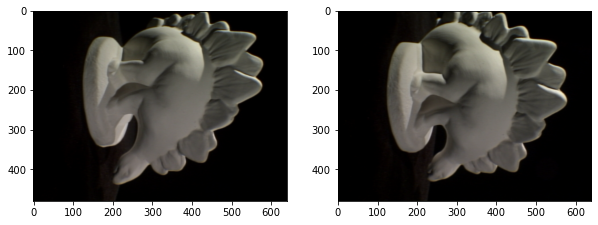

In [117]:
# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("dinoSparseRing/dinoSR0001.png")
imR = image.imread("dinoSparseRing/dinoSR0002.png")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

the number of features in images 1 and 2 are    39 and    36


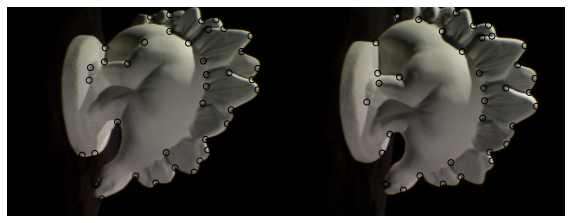

In [118]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.001, min_distance=15)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.001, min_distance=15)


print ('the number of features in images 1 and 2 are {:5d} and {:5d}'.format(keypointsL.shape[0],keypointsR.shape[0]))

fig = plt.figure(1,figsize = (10, 4))
axA = plt.subplot(111)
plt.gray()
matchesLR = np.empty((0,2))
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR)
axA.axis('off')

plt.show()

the number of matches is 24


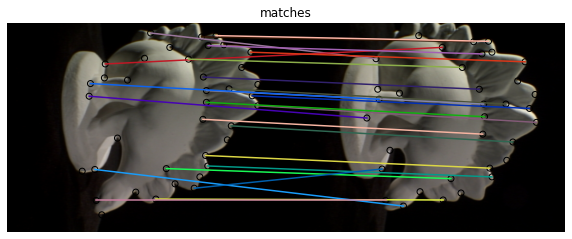

In [119]:
extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(2,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

the number of inliers is 10


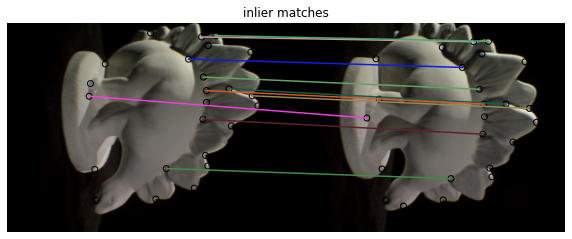

In [120]:
ptsL1 = []
ptsR1 = []
for i in matchesLR:
    ptsL1.append(keypointsL[i[0]])
    ptsR1.append(keypointsR[i[1]])
ptsL1 = np.array(ptsL1)
ptsR1 = np.array(ptsR1)

# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#advanced-indexing
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL = ptsL1[:,[1, 0]]
ptsR = ptsR1[:,[1, 0]]

# robustly estimate fundamental matrix using RANSAC
F_trans, F_inliers = ransac((ptsL, ptsR), FundamentalMatrixTransform, min_samples=8, residual_threshold=0.1, max_trials=1500)
print ('the number of inliers is {:2d}'.format(np.sum(F_inliers)))

ind = np.ogrid[:ptsL.shape[0]]
FmatchesRansac = np.column_stack((ind[F_inliers],ind[F_inliers]))

fig = plt.figure(3,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
# NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
plot_matches(axA, imL, imR, ptsL1, ptsR1, FmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()